In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_theme()
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, log_loss, confusion_matrix
import dill
from sklearn.metrics import r2_score
# scientific format off
pd.set_option('display.float_format', lambda x: '%.3f' % x)
np.set_printoptions(suppress=True)
# show all columns in pandas df
pd.set_option('display.max_columns', None)

# LOADING DATASET

In [2]:
path_train = '../dataset/train.csv'
path_macro = '../dataset/macro.csv'

In [3]:
X_train = pd.read_csv(path_train)
y_train = X_train.iloc[:, -1]
X_train = X_train.iloc[:, :-1]

macrostatistics will not be used in terms of api usage (need to add statistics collection)  
thats why we can delete timestamp columns (no need to merge with macrodata)

In [4]:
#add_features = pd.read_csv(path_macro)
X_train = X_train.drop(["id", "timestamp"], axis=1)
# saving json for testing
X_train.loc[1].to_json('test.json')

# ANALYSING DATASET
*clearing data*

In [5]:
X_train.describe()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25_raion,shopping_centers_raion,office_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road2_km,ID_big_road2,railroad_km,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_avg,cafe_avg_price_2000,cafe_count_2000_na_price,cafe_count_2000_price_500,cafe_count_2000_price_1000,cafe_count_2000_price_1500,cafe_count_2000_price_2500,cafe_count_2000_price_4000,cafe_count_2000_price_high,big_church_count_2000,church_count_2000,mosque_count_2000,leisure_coun

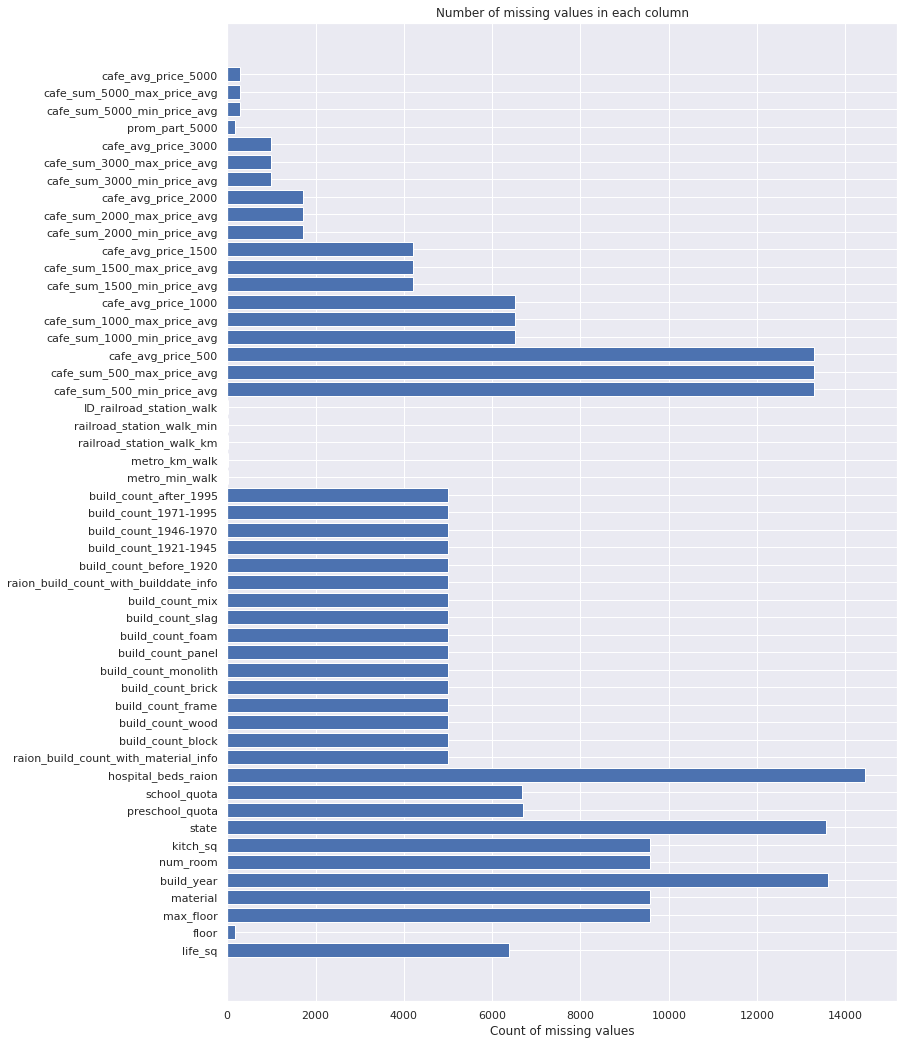

In [6]:
missing_df = X_train.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, )
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()

Pipeline workflow with get_dummies doesn't allow to analize feature importance

In [7]:
def numerize(df_all, need_scaler=False):
    df_numeric = df_all.select_dtypes(exclude=['object'])
    df_obj = df_all.select_dtypes(include=['object']).copy()
    # Deal with categorical values
    for c in df_obj:
        df_obj[c] = pd.factorize(df_obj[c])[0]
    if need_scaler:
        # Deal with numerical values
        scaler = StandardScaler()
        df_numeric = pd.DataFrame(scaler.fit_transform(df_numeric), columns=df_numeric.columns)
    return pd.concat([df_numeric, df_obj], axis=1)

In [12]:
X_train = numerize(X_train, False) # r2_score = 71%
# for test use in api cut to important features, but r2_score = 55%
# X_train = X_train[['full_sq', 'floor', 'life_sq', 'build_year',  'max_floor']]

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, shuffle=True, random_state=42)


# TRAIN MODEL

In [14]:
xgb_params = {
    'booster': 'gbtree',
    'eta': 0.05,
    'max_depth': 5,
    'learning_rate': 0.05,
    'min_child_weight': 4,
    'subsample': 1.0,
    'colsample_bytree': 0.7,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse'
}

dtrain = xgb.DMatrix(X_train.values, y_train.values, feature_names=X_train.columns)
model = xgb.train(xgb_params, dtrain, num_boost_round=1000)

# SCORE MODEL

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

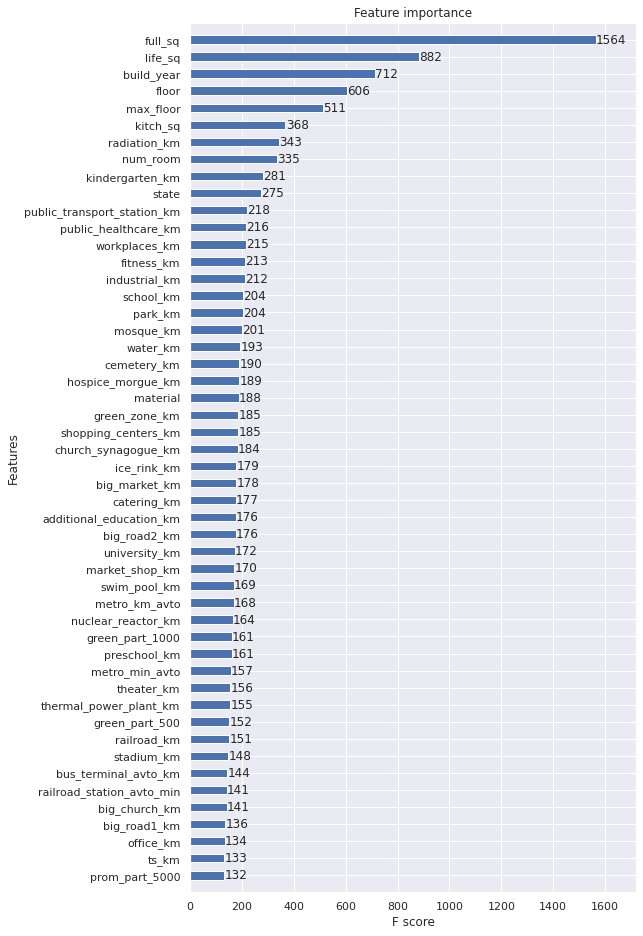

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

In [16]:
answers = model.predict(xgb.DMatrix(X_test.values, feature_names=X_test.columns))

In [17]:
r2_score(y_test, answers)

0.7112900238301045

# SAVING MODEL

In [18]:
with open('model.pkl', 'wb') as file:
    dill.dump(model, file)
# saving json for testing
X_train.loc[1].to_json('testnum.json')